# Basic Notebook

This is a first basic notebook to make sure that things are generally running.

In [1]:
import os.path
import io
import itertools

import numpy as np
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import matplotlib

from astropy.io import fits
from astropy.table import Table

from decimal import Decimal
import math

from utils import *

directory = '/media/craig/CA97-4BDA/dssi_dwarfs/'
info_file = os.path.join(directory, 'stamps2.ecsv')

Using TensorFlow backend.


## User Methods

In [2]:
def get_input(filename):
    """
    Loader function for teh data given a filename
    """
    
    f = fits.open(os.path.join(directory, filename))
    img = f[0].data.transpose((1, 2, 0))[16:-16,16:-16] # move channels to last
    return img


def get_output(dwarf_table_row, columns):    
    """
    Loader function for the y_true parameters.
    """
    
    return np.array([scale_column(column_scaling, c, dwarf_table_row[c]) for c in columns])

def preprocess_input(image):
    """
    Any preprocessing we want done... none at this point.
    """
    
#     --- Rescale Image
#     --- Rotate Image
#     --- Resize Image
#     --- Flip Image
#     --- PCA etc.
    
    return(image)


## Load the Information File

In [3]:
dwarfs_table = Table.read(info_file, format='ascii.ecsv')
dwarfs_table

<Table length=12558>
                      filename                       logmass ... noise_z noise_y
                       str52                         float64 ... float64 float64
---------------------------------------------------- ------- ... ------- -------
stamps2/d14.79_m7.45_re0.35_feh-1.2_age10.0_HSC.fits  7.4485 ...  0.0349  0.0164
stamps2/d12.46_m6.72_re0.44_feh-1.5_age12.6_HSC.fits  6.7190 ...  0.0245  0.0281
 stamps2/d9.81_m8.47_re0.84_feh-1.0_age12.3_HSC.fits  8.4725 ...  0.0251  0.0167
 stamps2/d14.38_m5.08_re0.47_feh-2.0_age7.0_HSC.fits  5.0823 ...  0.0365  0.0319
stamps2/d11.95_m8.55_re1.34_feh-1.0_age13.7_HSC.fits  8.5475 ...  0.0372  0.0224
  stamps2/d9.74_m5.33_re0.46_feh-1.8_age7.7_HSC.fits  5.3289 ...  0.0179  0.0166
stamps2/d10.94_m5.00_re0.95_feh-1.5_age13.2_HSC.fits  5.0040 ...  0.0202  0.0344
stamps2/d12.95_m5.07_re0.21_feh-2.0_age11.4_HSC.fits  5.0731 ...  0.0233  0.0198
 stamps2/d7.03_m6.23_re0.47_feh-1.8_age11.3_HSC.fits  6.2316 ...  0.0374  0.0274
stamps2/d11.57_m5.17_re0.22_feh-2.0_age11.7_HSC.fits  5.1709 ...  0.0338  0.0230
                                                 ...     ... ...     ...     ...
 stamps2/d3.73_m7.66_re0.45_feh-1.2_age13.1_HSC.fits  7.6571 ...  0.0174  0.0350
 stamps2/d10.51_m5.05_re0.19_feh-2.0_age9.7_HSC.fits  5.0504 ...  0.0291  0.0190
stamps2/d10.23_m8.55_re0.72_feh-1.2_age10.8_HSC.fits  8.5462 ...  0.0320  0.0177
stamps2/d11.71_m6.42_re0.63_feh-1.5_age10.1_HSC.fits  6.4168 ...  0.0397  0.0283
 stamps2/d3.68_m5.31_re0.53_feh-2.0_age14.0_HSC.fits  5.3101 ...  0.0324  0.0192
stamps2/d14.93_m5.67_re0.21_feh-2.0_age12.0_HSC.fits  5.6689 ...  0.0299  0.0189
 stamps2/d11.84_m7.86_re0.43_feh-1.2_age8.2_HSC.fits  7.8559 ...  0.0179  0.0350
  stamps2/d4.90_m7.64_re0.43_feh-1.0_age8.7_HSC.fits  7.6398 ...  0.0163  0.0305
stamps2/d14.13_m5.68_re0.35_feh-1.8_age10.2_HSC.fits  5.6786 ...  0.0234  0.0307
stamps2/d11.39_m8.88_re1.23_feh-1.0_age12.0_HSC.fits  8.8764 ...  0.0161  0.0344

## Setup the Columns of Interest

In [4]:
# Calculate the scale factors for each attribute
#columns = ['distance', 'logmass', 'rekpc', 'FeH', 'age']
columns = ['logmass']

column_scaling = {}
for column in columns:
    column_scaling[column] = {
      'min': np.percentile(dwarfs_table[column], 0.01), 
      'max': np.percentile(dwarfs_table[column], 99.99)  
    }

print('Columns Scaling is {}'.format(column_scaling))
print('min and max are {} and {}'.format(np.min(dwarfs_table[column]), np.max(dwarfs_table[column])))

Columns Scaling is {'logmass': {'min': 5.0002, 'max': 8.99742329}}
min and max are 5.0 and 8.9991


## Load the Data into Test and Train

plookup is [3.76335993e-05 7.35077918e-05 1.51240169e-04 2.90360046e-04]


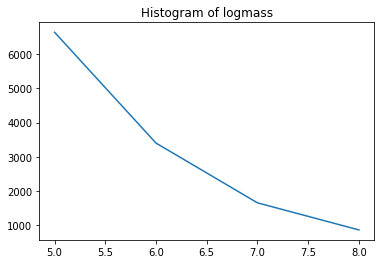

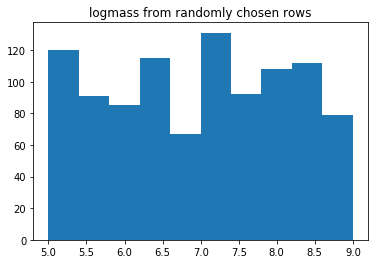

In [5]:
# Get a list of all row indices
indices = range(len(dwarfs_table))

# training indices
counts, bins = np.histogram(dwarfs_table['logmass'], np.arange(5, 10))

plt.plot(bins[:-1], counts)
plt.title('Histogram of logmass')

# Calculate the probability for each point with which we want it chosen.
plookup = (1 / len(counts)) * (1 / counts)
print('plookup is {}'.format(plookup))
probabilities = np.array([plookup[int(x)-5] for x in np.floor(dwarfs_table['logmass'])])

# As a test we are going to randomly choose 1000 points to make sure that what comes back is a uniform distribution
# of distances.
plt.figure()
out = np.random.choice(dwarfs_table['logmass'], 1000, p=probabilities)
plt.hist(out)
plt.title('logmass from randomly chosen rows')

# Now get the training, validation and test indices
training_test_indices = random_subsets(indices, [1000, 50, 25], probabilities=probabilities)
training_indices, validation_indices, test_indices = training_test_indices

## Compile the Neural Network

In [6]:
EPOCHS = 20
BATCH_SIZE = 32

model = keras.Sequential()

# 1st Convolutional Layer 
model.add(layers.Conv2D(filters=96, input_shape=(224,224,5), kernel_size=(5,5), strides=(4,4), padding='valid'))
model.add(layers.Activation('relu'))
# Pooling 
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
model.add(layers.BatchNormalization())

# 2nd Convolutional Layer
model.add(layers.Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(layers.Activation('relu'))
# Pooling
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(layers.BatchNormalization())


# Passing it to a dense layer
model.add(layers.Flatten())

# 1st Dense Layer
model.add(layers.Dense(1000, input_shape=(224*224*5,)))
model.add(layers.Activation('relu'))
# Add Dropout to prevent overfitting
model.add(layers.Dropout(0.2))
# Batch Normalisation
model.add(layers.BatchNormalization())

# 2nd Dense Layer
model.add(layers.Dense(1000))
model.add(layers.Activation('relu'))
# Add Dropout
model.add(layers.Dropout(0.2))
# Batch Normalisation
model.add(layers.BatchNormalization())

# 3rd Dense Layer
model.add(layers.Dense(1000))
model.add(layers.Activation('relu'))
# Add Dropout
model.add(layers.Dropout(0.2))
# Batch Normalisation
model.add(layers.BatchNormalization())

# Output Layer
model.add(layers.Dense(1))

model.summary()

from keras.optimizers import SGD
# sgd = SGD(lr=0.0001, momentum=0.9)
sgd = SGD()
model.compile(loss='mse', optimizer='adam')

W0807 22:33:04.204202 140510857929024 deprecation_wrapper.py:119] From /opt/venvs/neural/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 22:33:04.228146 140510857929024 deprecation_wrapper.py:119] From /opt/venvs/neural/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 22:33:04.233452 140510857929024 deprecation_wrapper.py:119] From /opt/venvs/neural/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 22:33:04.260306 140510857929024 deprecation_wrapper.py:119] From /opt/venvs/neural/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0807 22:33:04.285709 14051

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 55, 55, 96)        12096     
_________________________________________________________________
activation_1 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_2 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
__________

## Train the Neural Network

In [7]:
EPOCHS = 10
BATCH_SIZE = 32

train_generator = image_generator(dwarfs_table, training_indices, columns, get_input, get_output, batch_size=BATCH_SIZE)
validation_generator = image_generator(dwarfs_table, validation_indices, columns, get_input, get_output, batch_size=BATCH_SIZE)
test_generator = image_generator(dwarfs_table, test_indices, columns, get_input, get_output, batch_size=BATCH_SIZE)

steps_per_epoch = len(training_indices)//BATCH_SIZE
validation_steps = len(validation_indices)//BATCH_SIZE

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps,
                    shuffle=True, callbacks=[])


Epoch 1/10
31/31 [==============================] - 106s 3s/step - loss: 3.2559 - val_loss: 0.8032
Epoch 2/10
31/31 [==============================] - 47s 2s/step - loss: 0.9521 - val_loss: 0.1264
Epoch 3/10
31/31 [==============================] - 43s 1s/step - loss: 0.6053 - val_loss: 0.0667
Epoch 4/10
31/31 [==============================] - 43s 1s/step - loss: 0.5325 - val_loss: 0.1073
Epoch 5/10
31/31 [==============================] - 43s 1s/step - loss: 0.5292 - val_loss: 0.0297
Epoch 6/10
31/31 [==============================] - 43s 1s/step - loss: 0.5069 - val_loss: 0.1579
Epoch 7/10
31/31 [==============================] - 43s 1s/step - loss: 0.3832 - val_loss: 0.0260
Epoch 8/10
31/31 [==============================] - 43s 1s/step - loss: 0.3346 - val_loss: 0.0468
Epoch 9/10
31/31 [==============================] - 44s 1s/step - loss: 0.2994 - val_loss: 0.0398
Epoch 10/10
31/31 [==============================] - 43s 1s/step - loss: 0.2782 - val_loss: 0.0640


## Show Training Output

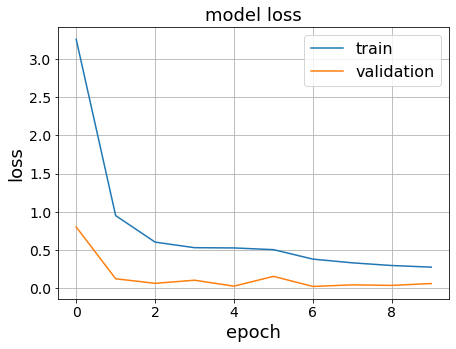

In [8]:
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)                                                                                                                                                                                               
#score = model.evaluate(test['features'], test['labels'])

plt.figure(2, figsize=[7, 5])
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.legend(['train', 'validation'], fontsize=16)
plt.grid('on')
plt.show()


## Show Results Compared to Truth

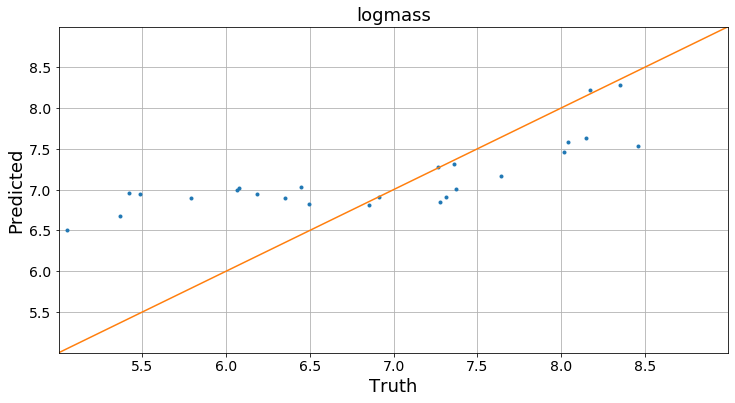

In [9]:
calculated = np.zeros((len(test_indices), len(columns)))
truth = np.zeros((len(test_indices), len(columns)))

for ii, test_indice in enumerate(test_indices):
    row = dwarfs_table[test_indice]
    
    data = get_input(row['filename'])

    values = model.predict(data[None,:])[0]

    for jj, c in enumerate(columns):
        cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
        values[jj] = values[jj] * (cmax - cmin) + cmin

    calculated[ii] = values
    truth[ii] = [row[c] for c in columns]


plt.figure(3, figsize=[12, 6])
plt.clf()

cs = int(np.ceil(np.sqrt(len(columns))))
rs = int(len(columns) // cs)

for ci, c in enumerate(columns):
    plt.subplot(rs, cs, ci+1)
    plt.plot(truth[:, ci], calculated[:, ci], '.')
    plt.title(c, fontsize=18)
    cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
    plt.xlim((cmin, cmax))
    plt.ylim((cmin, cmax))
    plt.grid('on')
    plt.xlabel('Truth', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.plot([cmin, cmax], [cmin, cmax])


Text(0.5, 0.98, 'Training Data [Subset]')

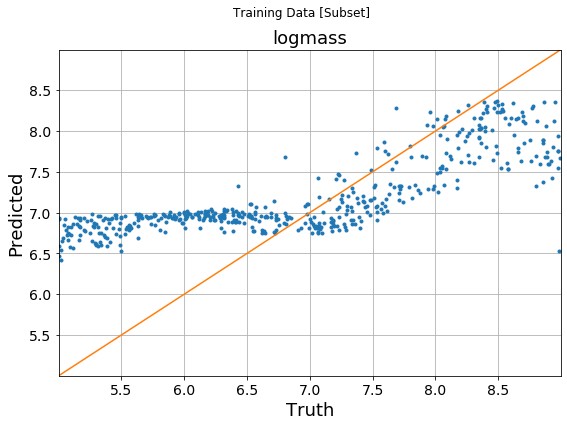

In [10]:
Ncompare = 500

calculated = np.zeros((Ncompare, len(columns)))
truth = np.zeros((Ncompare, len(columns)))

for ii, test_indice in enumerate(training_indices[:Ncompare]):
    row = dwarfs_table[test_indice]
    data = get_input(row['filename'])
    values = model.predict(data[None,:])[0]

    for jj, c in enumerate(columns):
        cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
        values[jj] = values[jj] * (cmax - cmin) + cmin

    calculated[ii] = values
    truth[ii] = [row[c] for c in columns]


plt.figure(3, figsize=[9, 6])
plt.clf()

cs = int(np.ceil(np.sqrt(len(columns))))
rs = int(len(columns) // cs)

for ci, c in enumerate(columns):
    plt.subplot(rs, cs, ci+1)
    plt.plot(truth[:, ci], calculated[:, ci], '.')
    plt.title(c, fontsize=18)
    cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
    plt.xlim((cmin, cmax))
    plt.ylim((cmin, cmax))
    plt.grid('on')
    plt.xlabel('Truth', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.plot([cmin, cmax], [cmin, cmax])
plt.suptitle('Training Data [Subset]')
